In [53]:
# import relevant packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.standard import Eof

### manipulating the datasets

In [54]:
# Load in the datasets 
sst = xr.open_dataset('sst_monthly.nc')['sst']
msl = xr.open_dataset('msl_monthly.nc')['msl']
u10 = xr.open_dataset('u10_monthly.nc')['u10']
v10 = xr.open_dataset('v10_monthly.nc')['v10']

In [55]:
# slice data for the specified region, 30S–30N, 100E–70W
region = dict(latitude=slice(30, -30), longitude=slice(100, 290)) # 70W == 360-70=290 degrees

# reduce datasets to information for the specified region only
# xr.sel selects the coordinates defined in region from dataset xr
sst_red = sst.sel(**region)
msl_red = msl.sel(**region)
u10_red = u10.sel(**region)
v10_red = v10.sel(**region)

In [56]:
# flatten spatial dimensions for SST
sst_flat = sst_red.stack(space=('latitude', 'longitude'))
sst_flat

<xarray.DataArray 'sst' (time: 459, space: 20493)>
array([[      nan,       nan,       nan, ..., 292.3171 ,       nan,
              nan],
       [      nan,       nan,       nan, ..., 292.92953,       nan,
              nan],
       [      nan,       nan,       nan, ..., 292.08813,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 291.14157,       nan,
              nan],
       [      nan,       nan,       nan, ..., 292.59717,       nan,
              nan],
       [      nan,       nan,       nan, ..., 291.4631 ,       nan,
              nan]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-03-01
  * space      (space) object MultiIndex
  * latitude   (space) float32 30.0 30.0 30.0 30.0 ... -30.0 -30.0 -30.0 -30.0
  * longitude  (space) float32 100.5 101.2 102.0 102.8 ... 288.0 288.8 289.5
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [57]:
# Identify sea coordinates (non-NaN points in SST) across all time steps
valid_points = ~sst_flat.isnull().any(dim='time')
valid_points

<xarray.DataArray 'sst' (space: 20493)>
array([False, False, False, ...,  True, False, False])
Coordinates:
  * space      (space) object MultiIndex
  * latitude   (space) float32 30.0 30.0 30.0 30.0 ... -30.0 -30.0 -30.0 -30.0
  * longitude  (space) float32 100.5 101.2 102.0 102.8 ... 288.0 288.8 289.5

In [58]:
# Reduce SST to only valid (ocean) points
sst_sea = sst_flat[:, valid_points]
sst_sea         # note reduced number of points in the space dimension

<xarray.DataArray 'sst' (time: 459, space: 17874)>
array([[285.3378 , 285.66473, 286.2303 , ..., 292.76547, 292.5437 ,
        292.3171 ],
       [285.11905, 285.55957, 286.1227 , ..., 293.17532, 293.0858 ,
        292.92953],
       [285.24164, 285.49948, 285.79517, ..., 292.45413, 292.26483,
        292.08813],
       ...,
       [284.68634, 288.4834 , 289.90234, ..., 292.08694, 291.86877,
        291.14157],
       [282.95007, 286.63834, 287.874  , ..., 293.25345, 293.3388 ,
        292.59717],
       [283.96814, 286.26633, 287.1414 , ..., 293.25226, 292.77988,
        291.4631 ]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-03-01
  * space      (space) object MultiIndex
  * latitude   (space) float32 30.0 30.0 30.0 30.0 ... -30.0 -30.0 -30.0 -30.0
  * longitude  (space) float32 122.2 123.0 123.8 124.5 ... 286.5 287.2 288.0
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [141]:
len(sst_sea.latitude)

17874

In [59]:
# flatten and retain complete grids for the other variables
msl_flat = msl_red.stack(space=('latitude', 'longitude'))
u10_flat = u10_red.stack(space=('latitude', 'longitude'))
v10_flat = v10_red.stack(space=('latitude', 'longitude'))

In [60]:
# Normalize each dataset
# procedure: subtract the mean and divide by the standard deviation
def normalize(data):
    mean = data.mean(dim='time', skipna=True)
    std = data.std(dim='time', skipna=True)
    return (data - mean) / std

sst_normalised = normalize(sst_sea)
msl_normalised = normalize(msl_flat)
u10_normalised = normalize(u10_flat)
v10_normalised = normalize(v10_flat)

In [61]:
# view the dataset(s) to check they've been normalised
v10_normalised

<xarray.DataArray 'v10' (time: 459, space: 20493)>
array([[-0.5336432 , -0.70928574, -0.9194969 , ..., -0.56060916,
         0.49620757,  1.7021706 ],
       [ 0.52833897, -0.04358068, -0.7083248 , ...,  0.10459466,
         0.63424027,  1.0362582 ],
       [ 0.692189  ,  0.4307313 ,  0.15044239, ...,  0.22163938,
         0.6066341 ,  1.0026273 ],
       ...,
       [ 1.4689503 ,  1.2129306 ,  0.7558009 , ...,  0.46743393,
         0.68025   ,  1.7627085 ],
       [-0.01175409,  0.17277099, -0.37044838, ...,  0.4401228 ,
         0.8688956 ,  1.042985  ],
       [ 1.4325399 ,  1.0298625 ,  0.7839587 , ...,  0.79710954,
         0.8504903 ,  0.24927258]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-03-01
  * space      (space) object MultiIndex
  * latitude   (space) float32 30.0 30.0 30.0 30.0 ... -30.0 -30.0 -30.0 -30.0
  * longitude  (space) float32 100.5 101.2 102.0 102.8 ... 288.0 288.8 289.5

In [62]:
# Concatenate normalised datasets into a single matrix *
datasets = [sst_normalised, msl_normalised, u10_normalised, v10_normalised]

# *along a new 'variable' dimension - this doesn't work with Eof, see last section below
combined_data = xr.concat(datasets, dim='variable')

# *along the time dimension - results in 4x the number of temporal data points
combined_data2 = xr.concat(datasets, dim = 'time')
combined_data2

<xarray.DataArray 'sst' (time: 1836, space: 20493)>
array([[ 1.1298177 ,  1.1616446 ,  1.1803051 , ..., -0.80703354,
        -0.8138178 , -0.81059253],
       [ 1.3060466 ,  1.3412886 ,  1.359005  , ..., -1.1876628 ,
        -1.1949749 , -1.2229441 ],
       [ 1.1951065 ,  1.2177637 ,  1.2316285 , ..., -1.1435136 ,
        -1.2014195 , -1.2714493 ],
       ...,
       [ 1.2661461 ,  1.3656709 ,  1.4569535 , ..., -0.26991013,
        -0.28994992, -0.29891756],
       [ 1.4345305 ,  1.5436243 ,  1.5691136 , ..., -0.12152899,
        -0.09151222, -0.02501304],
       [ 1.3955362 ,  1.408041  ,  1.4049371 , ..., -1.2137333 ,
        -1.2313752 , -1.2483507 ]], dtype=float32)
Coordinates:
  * space      (space) object MultiIndex
  * latitude   (space) float32 -30.0 -30.0 -30.0 -30.0 ... 30.0 30.0 30.0 30.0
  * longitude  (space) float32 100.5 101.2 102.0 102.8 ... 288.0 288.8 289.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-03-01

### using the Eof package to find solutions

In [63]:
# perform EOF analysis using the eofs library, after 
data_matrix = combined_data2.fillna(0).values       # should we be masking the NaNs instead?
solver = Eof(data_matrix)

In [64]:
# Compute 4 EOFs (spatial patterns) and 1 PC (time series)
eofs = solver.eofs(neofs=4)
pcs = solver.pcs(npcs=1)

In [65]:
""" you can see that there are 4x as many time points as we want"""
xvals = sst.time.to_numpy()
print(len(xvals)*4, len(pcs))

1836 1836


### plotting

In [66]:
# saving indices and years every 75 years (just to make the plot less cluttered on the x axis)
indices =[]
years = []
for i, year in enumerate(xvals):
    if i%75 == 0:
        indices.append(i)
        years.append(year.astype('datetime64[Y]').astype(int) + 1970)

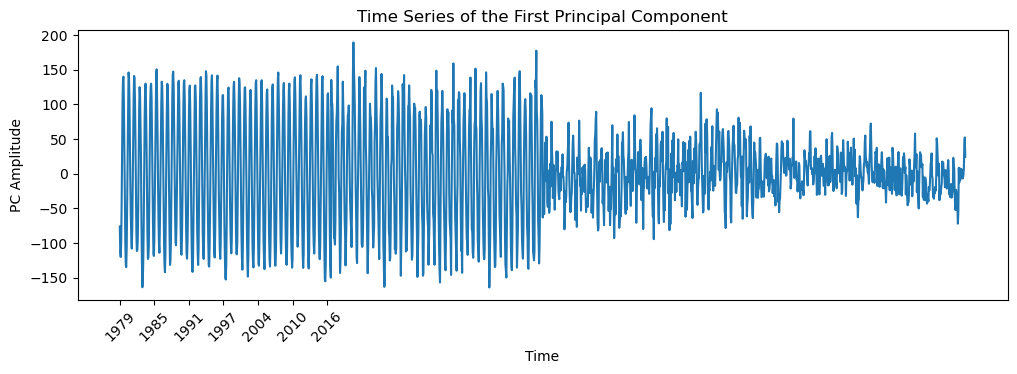

In [67]:
# Plot the single PC (time series) for the first 4 EOFs
plt.figure(figsize = (12,3.5))
plt.plot(pcs)
plt.xticks(indices, years, rotation = 45)
plt.title('Time Series of the First Principal Component')
plt.xlabel('Time')
plt.ylabel('PC Amplitude')
plt.show()

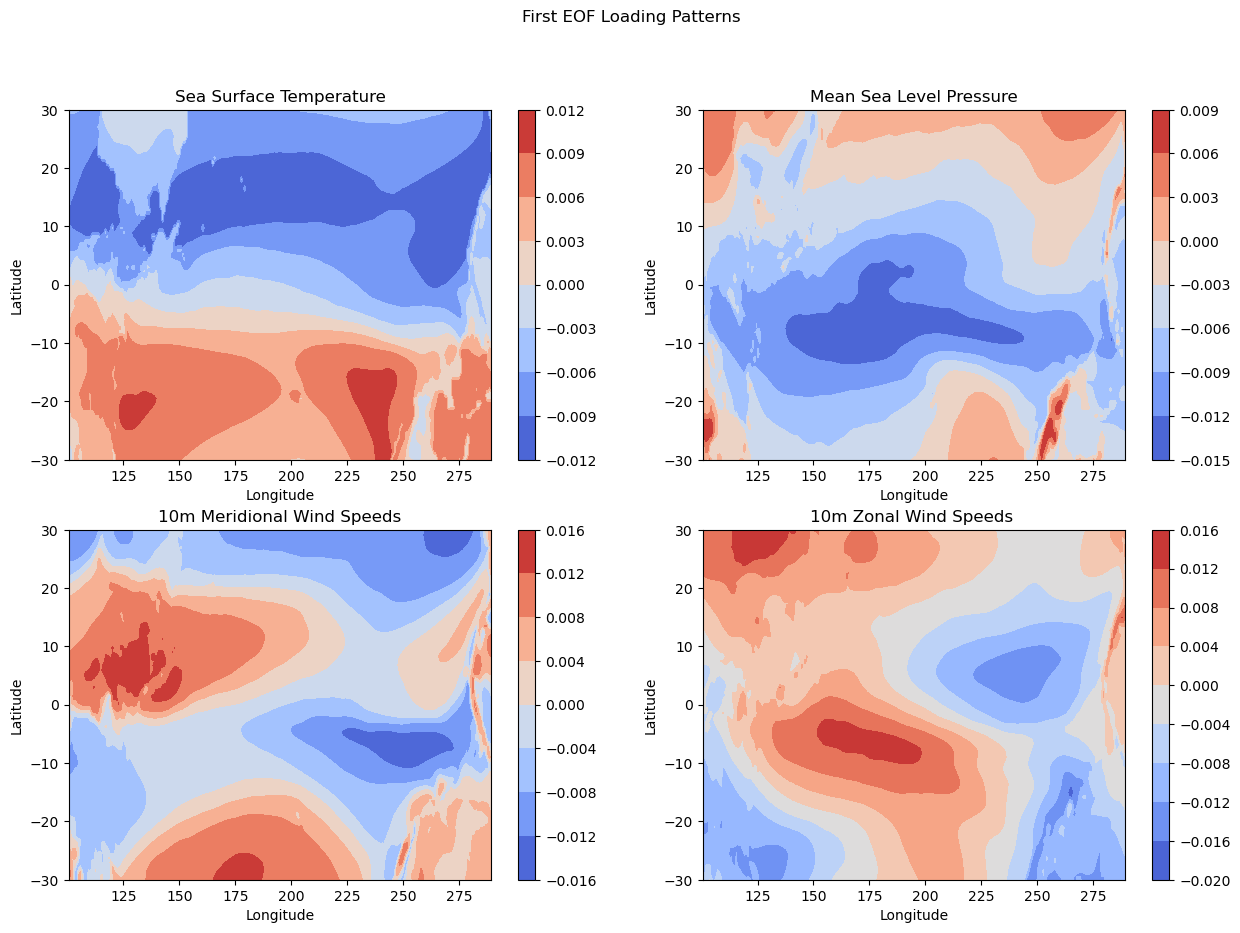

In [68]:
# function to plot the loading patterns (contour maps) of the EOF analyses
# INPUT: contours = list of information to be plotted, currently of length 3 but will be length 4 when sst is figured out
# TO DO: figure out how to get a colour map on each subplot
def plot_loadingPatterns(contours):

    # prepare figure
    fig, ax = plt.subplots(2,2, figsize = (15,10))
    ax=ax.ravel()

    # titles for the subplots
    names = ["Sea Surface Temperature",
             "Mean Sea Level Pressure",
             "10m Meridional Wind Speeds",
             "10m Zonal Wind Speeds "]
    
    
    # plot each of the loading patterns
    for i in range(4):

        # this variable's loading pattern (?) reshaped into the physical coordinate grid
        eof1_spatial = contours[i].reshape((len(sst_red['latitude']), len(sst_red['longitude'])))
        
        # contour plot of the loading pattern
        T = ax[i].contourf(sst_red['longitude'], sst_red['latitude'], eof1_spatial, cmap='coolwarm')
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        plt.colorbar(T, ax=ax[i])
    
    # need to add a colourbar
    plt.suptitle("First EOF Loading Patterns")
    plt.show()

plot_loadingPatterns(eofs)

### RETRY

In [74]:
# slice data for the specified region, 30S–30N, 100E–70W
region = dict(latitude=slice(30, -30), longitude=slice(100, 290)) # 70W == 360-70=290 degrees

# reduce datasets to information for the specified region only
# xr.sel selects the coordinates defined in region from dataset xr
sst_red = sst.sel(**region)
msl_red = msl.sel(**region)
u10_red = u10.sel(**region)
v10_red = v10.sel(**region)

In [76]:
# flatten spatial dimensions for all variables
msl_flat = msl_red.stack(space=('latitude', 'longitude'))
u10_flat = u10_red.stack(space=('latitude', 'longitude'))
v10_flat = v10_red.stack(space=('latitude', 'longitude'))
sst_flat = sst_red.stack(space=('latitude', 'longitude'))

# Identify sea coordinates (non-NaN points in SST) across all time steps
valid_points = ~sst_flat.isnull().any(dim='time')
# Reduce SST to only valid (ocean) points
sst_sea = sst_flat[:, valid_points]
# sst_sea         # note reduced number of points in the space dimension

In [ ]:
# saving some information for plotting later

# physical grid points
lat = msl_red['latitude'].to_numpy()
lon = msl_red['longitude'].to_numpy()

array([ 30.  ,  29.25,  28.5 ,  27.75,  27.  ,  26.25,  25.5 ,  24.75,
        24.  ,  23.25,  22.5 ,  21.75,  21.  ,  20.25,  19.5 ,  18.75,
        18.  ,  17.25,  16.5 ,  15.75,  15.  ,  14.25,  13.5 ,  12.75,
        12.  ,  11.25,  10.5 ,   9.75,   9.  ,   8.25,   7.5 ,   6.75,
         6.  ,   5.25,   4.5 ,   3.75,   3.  ,   2.25,   1.5 ,   0.75,
         0.  ,  -0.75,  -1.5 ,  -2.25,  -3.  ,  -3.75,  -4.5 ,  -5.25,
        -6.  ,  -6.75,  -7.5 ,  -8.25,  -9.  ,  -9.75, -10.5 , -11.25,
       -12.  , -12.75, -13.5 , -14.25, -15.  , -15.75, -16.5 , -17.25,
       -18.  , -18.75, -19.5 , -20.25, -21.  , -21.75, -22.5 , -23.25,
       -24.  , -24.75, -25.5 , -26.25, -27.  , -27.75, -28.5 , -29.25,
       -30.  ], dtype=float32)

In [77]:
# Normalize each dataset - i.e. obtain anomaly matrices
# procedure: subtract the mean and divide by the standard deviation
def normalize(data):
    mean = data.mean(dim='time', skipna=True)
    std = data.std(dim='time', skipna=True)
    return (data - mean) / std

sst_normalised = normalize(sst_sea)
msl_normalised = normalize(msl_flat)
u10_normalised = normalize(u10_flat)
v10_normalised = normalize(v10_flat)

In [ ]:
# show the time and space dimensions of the normalised anomaly data
print(sst_normalised.shape)
print(msl_normalised.shape)
print(u10_normalised.shape)
print(v10_normalised.shape)

(459, 17874)
(459, 20493)
(459, 20493)
(459, 20493)


In [93]:
sst_normalised.shape[1]

17874

###  trying to append the anomaly matrices in the way sebastian suggested

In [ ]:
# Concatenate normalised datasets into a single matrix *
datasets = [sst_normalised, msl_normalised, u10_normalised, v10_normalised]

# concatenating along the SPATIAL DIMENSION
combined_data = xr.concat(datasets, dim='space')


In [ ]:
# so far so good
print(combined_data.shape)
print(17874+3*20493)

(459, 79353)
79353


In [86]:
# perform EOF analysis using the eofs library, after 
data_matrix = combined_data.fillna(0).values       # should we be masking the NaNs instead?
solver = Eof(data_matrix)

In [87]:
# Compute 4 EOFs (spatial patterns) and 1 PC (time series)
eofs = solver.eofs(neofs=4)
pcs = solver.pcs(npcs=1)

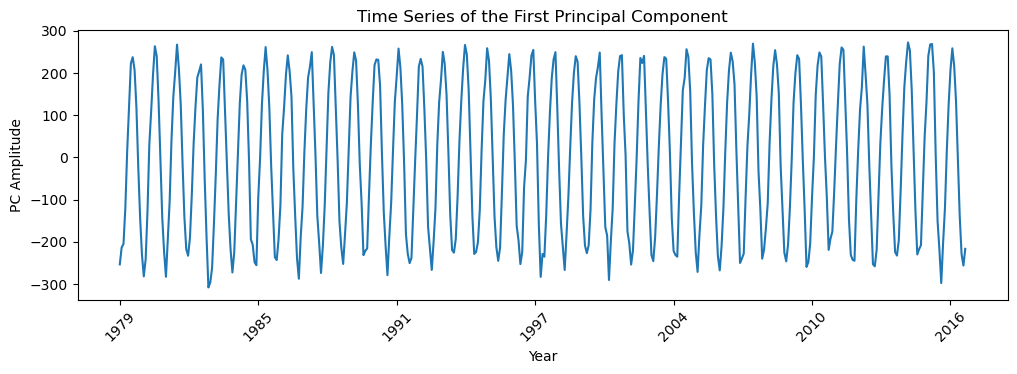

In [92]:
def plotTimeSeries():
    # saving indices and years every 75 years (just to make the plot less cluttered on the x axis)
    indices =[]
    years = []
    for i, year in enumerate(xvals):
        if i%75 == 0:
            indices.append(i)
            years.append(year.astype('datetime64[Y]').astype(int) + 1970)
    # Plot the single PC (time series) for the first 4 EOFs
    plt.figure(figsize = (12,3.5))
    plt.plot(pcs)
    plt.xticks(indices, years, rotation = 45)
    plt.title('Time Series of the First Principal Component')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')
    plt.show()
plotTimeSeries()

In [100]:
np.shape(eofs[0][:17874])

(17874,)

In [120]:
sst_normalised[1].shape[0]

17874

In [162]:
eofs[0].shape
lat

array([ 30.  ,  29.25,  28.5 ,  27.75,  27.  ,  26.25,  25.5 ,  24.75,
        24.  ,  23.25,  22.5 ,  21.75,  21.  ,  20.25,  19.5 ,  18.75,
        18.  ,  17.25,  16.5 ,  15.75,  15.  ,  14.25,  13.5 ,  12.75,
        12.  ,  11.25,  10.5 ,   9.75,   9.  ,   8.25,   7.5 ,   6.75,
         6.  ,   5.25,   4.5 ,   3.75,   3.  ,   2.25,   1.5 ,   0.75,
         0.  ,  -0.75,  -1.5 ,  -2.25,  -3.  ,  -3.75,  -4.5 ,  -5.25,
        -6.  ,  -6.75,  -7.5 ,  -8.25,  -9.  ,  -9.75, -10.5 , -11.25,
       -12.  , -12.75, -13.5 , -14.25, -15.  , -15.75, -16.5 , -17.25,
       -18.  , -18.75, -19.5 , -20.25, -21.  , -21.75, -22.5 , -23.25,
       -24.  , -24.75, -25.5 , -26.25, -27.  , -27.75, -28.5 , -29.25,
       -30.  ], dtype=float32)

In [225]:
sst_sep = sst_sea.unstack('space')
sst_lat = sst_sep['latitude'].to_numpy()
sst_lon = sst_sep['longitude'].to_numpy()
sst_sep

<xarray.DataArray 'sst' (time: 459, latitude: 81, longitude: 253)>
array([[[      nan,       nan,       nan, ..., 294.95126, 294.87012,
         294.8611 ],
        [      nan,       nan,       nan, ..., 295.31125, 295.25296,
         295.25177],
        [      nan,       nan,       nan, ..., 295.66583, 295.65442,
         295.6448 ],
        ...,
        [294.7854 , 294.83286, 294.87793, ..., 292.9043 , 290.57123,
               nan],
        [294.64838, 294.69165, 294.71088, ..., 292.46558,       nan,
               nan],
        [294.45004, 294.47287, 294.47467, ..., 292.3171 ,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 293.85806, 293.7691 ,
         293.67056],
        [      nan,       nan,       nan, ..., 294.2517 , 294.16577,
         294.08765],
        [      nan,       nan,       nan, ..., 294.64597, 294.58646,
         294.52878],
...
        [294.65198, 294.70667, 294.774  , ..., 293.98907, 290.19202,
               nan],
        [294.27875, 294.38452, 294.45847, ..., 292.76605,       nan,
               nan],
        [294.1724 , 294.14532, 294.28476, ..., 292.59717,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 294.0197 , 294.19763,
         294.2415 ],
        [      nan,       nan,       nan, ..., 294.432  , 294.52997,
         294.50354],
        [      nan,       nan,       nan, ..., 294.9705 , 295.0348 ,
         294.74152],
        ...,
        [294.8611 , 294.75714, 294.83047, ..., 293.41333, 289.48163,
               nan],
        [294.60568, 294.54077, 294.5973 , ..., 291.92526,       nan,
               nan],
        [294.35208, 294.4242 , 294.3785 , ..., 291.4631 ,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 30.0 29.25 28.5 27.75 ... -28.5 -29.25 -30.0
  * longitude  (longitude) float32 100.5 101.2 102.0 102.8 ... 288.0 288.8 289.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-03-01
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [157]:
t = np.array([ [1,2,3,4,5,6,7,8]]).reshape(2,4)
t

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

<class 'numpy.ndarray'>
20493


UnboundLocalError: cannot access local variable 'spatial' where it is not associated with a value

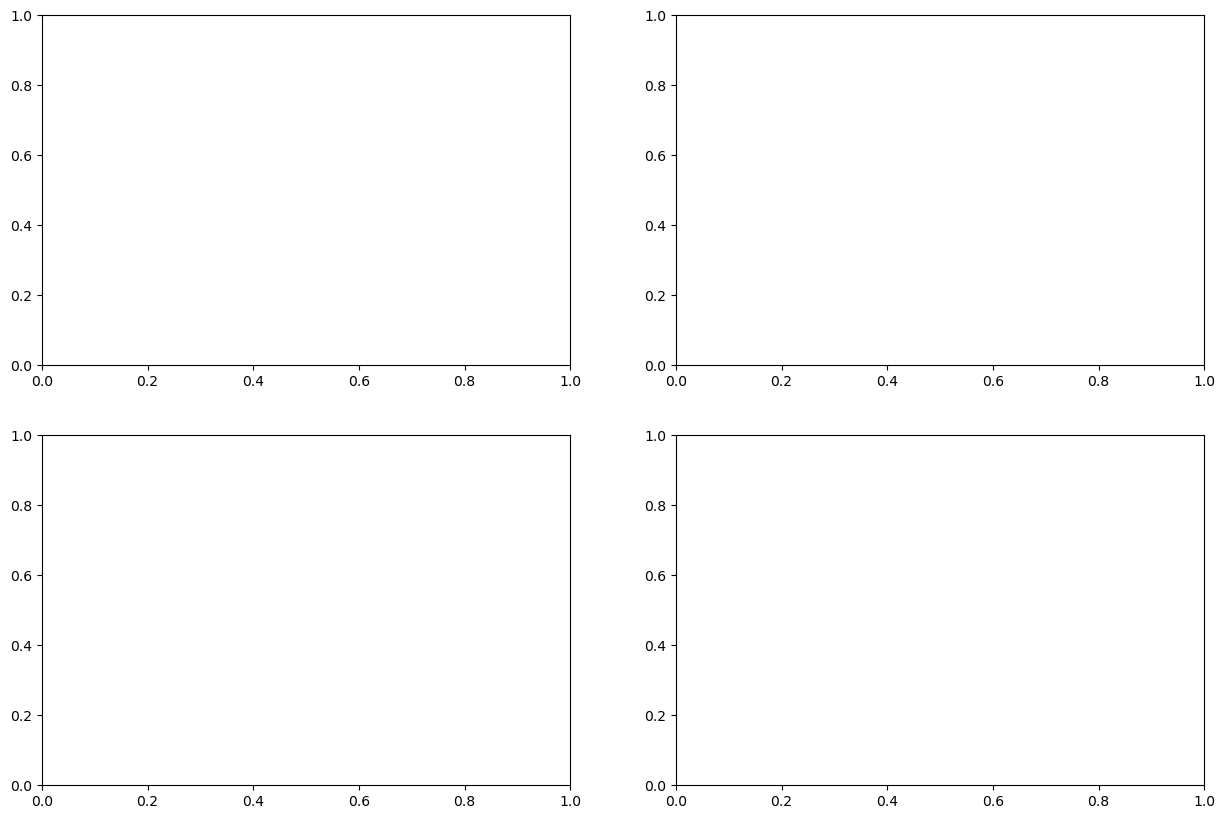

In [221]:
# function to plot the loading patterns (contour maps) of the EOF analyses
# INPUT: contours = list of information to be plotted, currently of length 3 but will be length 4 when sst is figured out
# TO DO: figure out how to get a colour map on each subplot
def plot_loadingPatterns(loadings):

    # prepare figure
    fig, ax = plt.subplots(2,2, figsize = (15,10))
    ax=ax.ravel()

    # titles for the subplots
    names = ["Sea Surface Temperature",
             "Mean Sea Level Pressure",
             "10m Meridional Wind Speeds",
             "10m Zonal Wind Speeds "]
    
    # how far along the matrix we need to go for each variable (word better)
    data = [sst_normalised[1],
                 msl_normalised[1],
                 u10_normalised[1],
                 v10_normalised[1] ]
   
    # holds the final coordinate dimensions for plotting
    shapes = [sst_sea,
              msl_red,
              u10_red,
              v10_red]
    
    # plot each of the loading patterns
    for i in range(4):

        # look at this particular eof
        eof_i = loadings[i]

        # relevant number of points for the ith dataset
        numpoints_i = data[i]

        # extract section of the data matrix relevant for this variable: has dims (1, lon x lat)
        # using the dimensions of the normalised datasets, since they have dims (time, lon x lat)
        if i == 0:
            block = eof_i[:numpoints_i.shape[0]]
            print(type(block))


            # need to put the sst points back onto their actual coordinates
            canvas = np.zeros( [len(lat), len(lon)] )

            # finding indices of the sea coordinates in the whole area
            coords = []

            for x in sst_lon:
                for y in sst_lat:
                    ind_x = int(np.where(lon == x)[0][0])
                    ind_y = int(np.where(lat == y)[0][0])
                    coords.append([ind_x, ind_y])
            print(len(coords))
            # rows, cols = sst_lon, sst_lat
            # canvas[rows,cols] = block

            # # reshape the block into loading pattern on physical coordinate grid of 30N-30S, 100E-70W
            # spatial = canvas

        else:

            # select the block of data corresponding to this variable
            start = data[i-1].shape[0]
            end = data[i-1].shape[0] + numpoints_i.shape[0]
            block = eof_i[start:end]
            print("block length", len(block))
            print("lat x lon", len(lat)*len(lon))

            # reshape the block into loading pattern on physical coordinate grid of 30N-30S, 100E-70W
            spatial = block.reshape( len(lat), len(lon) )
        

       
        # contour plot of the loading pattern
        T = ax[i].contourf(lon, lat, spatial, cmap='coolwarm')
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        plt.colorbar(T, ax=ax[i])
    
    # need to add a colourbar
    plt.suptitle("First EOF Loading Patterns")
    plt.show()

plot_loadingPatterns(eofs)

In [175]:
x = np.zeros([5,3])
x

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
x = np.zeros([5,3])

coords = np.array([ [1,2], [4,2], [4,1]])

rows, cols = coords[:, 0], coords[:, 1]

vals = [6,7,8]
x[rows,cols] = vals
x

array([[0., 0., 0.],
       [0., 0., 6.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 8., 7.]])

In [220]:
np.where(rows == 5)

(array([], dtype=int64),)

In [222]:
# Small subset of coordinates
small_coords = np.array([[1, 2], [3, 4], [0, 1]])

# Larger complete array of coordinates (e.g., grid points)
large_coords = np.array([
    [0, 0],
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5]
])

# Find indices of small_coords in large_coords
indices = [np.where((large_coords == coord).all(axis=1))[0][0] for coord in small_coords]

print(indices)

[2, 4, 1]


### TOMORROW
- find coordinates of sea data IN the new canvas in order to plot
- think about if we really need neofs = 4 